# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [1]:
!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

^C


### 1.2 Collect Images Using OpenCV

In [1]:
import os
import time
import uuid
import cv2
from tensorflow.keras.models import load_model
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [7]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [10]:
cap = cv2.VideoCapture(1)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'


### 1.3 Annotate Images with LabelMe

In [ ]:
!labelme

# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [7]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [12]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [13]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 2.3 Load Image into TF Data Pipeline

In [14]:
69*.7 #48

48.3

In [15]:
69*.15  #10 ve 11

10.35

In [16]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data\\images\\*.jpg'

In [ ]:
images.as_numpy_iterator().next()

In [17]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
images = images.map(load_image)

In [ ]:
images.as_numpy_iterator().next()

In [ ]:
type(images)

### 2.4 View Raw Images with Matplotlib

In [ ]:
image_generator = images.batch(4).as_numpy_iterator()

In [ ]:
plot_images = image_generator.next()

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [ ]:
90*.7 # 63 to train

In [ ]:
90*.15 # 14 and 13 to test and val

### 3.2 Move the Matching Labels

In [18]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [19]:
import albumentations as alb

In [20]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [23]:
img = cv2.imread(os.path.join('data','train', 'images','0db45e61-71c0-11ed-a584-70c94e8f3b82.jpg'))

In [24]:
with open(os.path.join('data', 'train', 'labels', '0db45e61-71c0-11ed-a584-70c94e8f3b82.json'), 'r') as f:
    label = json.load(f)

In [25]:
label['shapes'][0]['points']

[[244.47552447552448, 3.636363636363626],
 [473.1468531468531, 294.5454545454545]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [26]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [27]:
coords

[244.47552447552448, 3.636363636363626, 473.1468531468531, 294.5454545454545]

In [28]:
coords = list(np.divide(coords, [640,480,640,480]))

In [29]:
coords

[0.381993006993007,
 0.007575757575757554,
 0.739291958041958,
 0.6136363636363635]

### 4.4 Apply Augmentations and View Results

In [30]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [31]:
augmented['bboxes'][0][2:]

(0.6425485625485625, 0.6056565656565656)

In [32]:
augmented['bboxes']

[(0.13439005439005441, 0.0, 0.6425485625485625, 0.6056565656565656)]

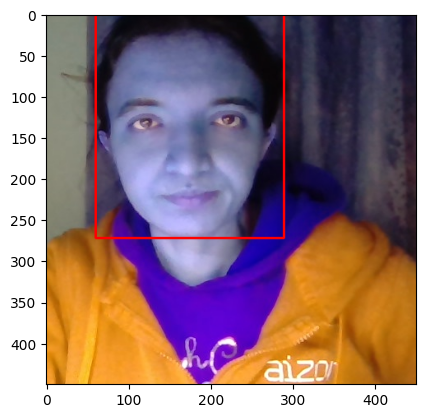

In [33]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [34]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset

In [35]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [36]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [37]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [38]:
train_images.as_numpy_iterator().next()

array([[[0.40637255, 0.4759804 , 0.44754902],
        [0.40245098, 0.49871323, 0.46439952],
        [0.4064951 , 0.48492646, 0.43786764],
        ...,
        [0.7221814 , 0.77071077, 0.8579657 ],
        [0.6804534 , 0.74938726, 0.85128677],
        [0.5959559 , 0.6826593 , 0.7738358 ]],

       [[0.40539217, 0.48382354, 0.44362745],
        [0.40484068, 0.48664215, 0.45839462],
        [0.4122549 , 0.4740809 , 0.43762255],
        ...,
        [0.7456495 , 0.8459559 , 0.8704657 ],
        [0.70055145, 0.85398287, 0.9141544 ],
        [0.71090686, 0.8497549 , 0.90655637]],

       [[0.39393383, 0.48805147, 0.4346201 ],
        [0.40490195, 0.4867647 , 0.45147058],
        [0.4122549 , 0.47892156, 0.44754902],
        ...,
        [0.45471814, 0.5797794 , 0.6985294 ],
        [0.40232843, 0.5754902 , 0.81868875],
        [0.3295956 , 0.534375  , 0.82101715]],

       ...,

       [[0.37843138, 0.45686275, 0.40980393],
        [0.36813724, 0.44656864, 0.4034314 ],
        [0.36121324, 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [39]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [40]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [41]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [42]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [43]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8), array([0.426, 0.373, 0.929, 1.   ], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [44]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(2880, 2880, 660, 660, 600, 600)

### 7.2 Create Final Datasets (Images/Labels)

In [45]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [46]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [47]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [48]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.      , 0.012245, 0.3887  , 0.794   ],
        [0.551   , 0.3286  , 1.      , 0.995   ],
        [0.0752  , 0.3123  , 0.655   , 1.      ],
        [0.      , 0.03226 , 0.5864  , 0.814   ],
        [0.739   , 0.368   , 1.      , 1.      ],
        [0.      , 0.2825  , 0.3655  , 1.      ],
        [0.2369  , 0.      , 0.7764  , 0.656   ],
        [0.4683  , 0.393   , 0.9717  , 1.      ]], dtype=float16))

### 7.3 View Images and Annotations

In [49]:
data_samples = train.as_numpy_iterator()

In [50]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


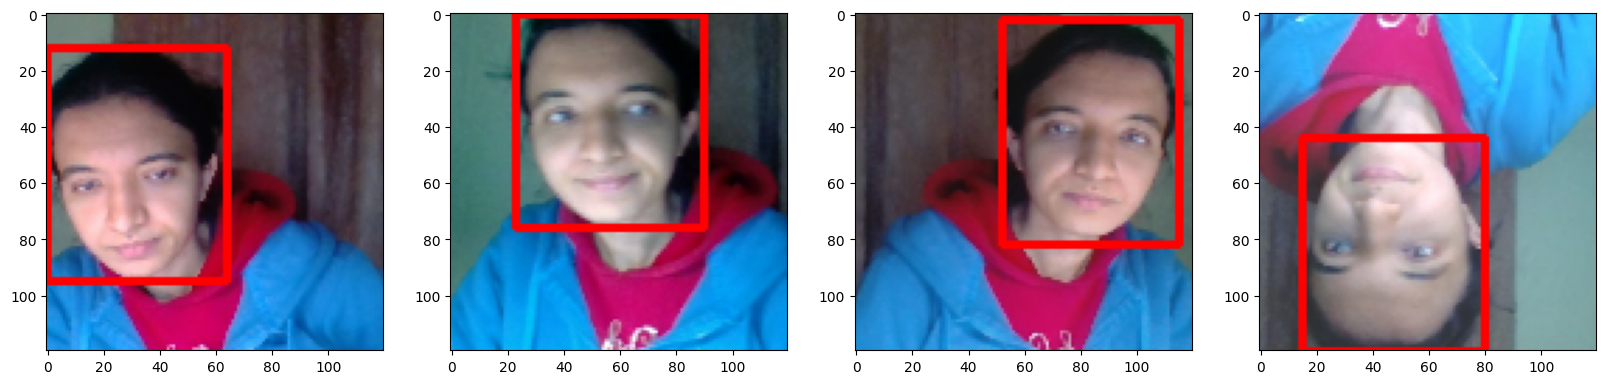

In [51]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [53]:
vgg = VGG16(include_top=False)

In [54]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [55]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [56]:
facetracker = build_model()

In [57]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [58]:
X, y = train.as_numpy_iterator().next()

In [59]:
X.shape

(8, 120, 120, 3)

In [60]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 13s 13s/step


In [61]:
classes, coords

(array([[0.53215647],
        [0.587371  ],
        [0.48595846],
        [0.5054525 ],
        [0.49577105],
        [0.5332302 ],
        [0.53164816],
        [0.51470256]], dtype=float32),
 array([[0.56694555, 0.42552122, 0.4506636 , 0.6287925 ],
        [0.46759668, 0.40768397, 0.5548751 , 0.60526174],
        [0.4534865 , 0.38237372, 0.4351954 , 0.6271979 ],
        [0.5283253 , 0.3807195 , 0.44731265, 0.7381522 ],
        [0.58150816, 0.46319482, 0.4943512 , 0.69516945],
        [0.5804853 , 0.46495003, 0.50411147, 0.6543961 ],
        [0.57090926, 0.40757352, 0.4769269 , 0.6698455 ],
        [0.566739  , 0.43879825, 0.47840366, 0.71251637]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [4]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

NameError: name 'train' is not defined

In [63]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [64]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [65]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [66]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.7786627>

In [67]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6491538>

In [68]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.7786627>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [69]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [70]:
model = FaceTracker(facetracker)

In [71]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [72]:
logdir='logs'

In [73]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [74]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
360/360 [==============================] - 61s 148ms/step - total_loss: 0.3655 - class_loss: 0.0778 - regress_loss: 0.3266 - val_total_loss: 2.0248 - val_class_loss: 0.8049 - val_regress_loss: 1.6223
Epoch 2/10
360/360 [==============================] - 55s 139ms/step - total_loss: 0.0916 - class_loss: 0.0215 - regress_loss: 0.0808 - val_total_loss: 0.2416 - val_class_loss: 0.0071 - val_regress_loss: 0.2380
Epoch 3/10
360/360 [==============================] - 57s 145ms/step - total_loss: 0.0551 - class_loss: 0.0125 - regress_loss: 0.0489 - val_total_loss: 0.7335 - val_class_loss: 0.0036 - val_regress_loss: 0.7317
Epoch 4/10
360/360 [==============================] - 64s 163ms/step - total_loss: 0.0385 - class_loss: 0.0084 - regress_loss: 0.0343 - val_total_loss: 0.9494 - val_class_loss: 0.0043 - val_regress_loss: 0.9472
Epoch 5/10
360/360 [==============================] - 64s 163ms/step - total_loss: 0.0268 - class_loss: 0.0057 - regress_loss: 0.0240 - val_total_loss: 1.77

### 10.3 Plot Performance

In [75]:
hist.history

{'total_loss': [0.0670461356639862,
  0.048907529562711716,
  0.008516253903508186,
  0.01042347215116024,
  0.8044908046722412,
  0.008326146751642227,
  0.004138057120144367,
  0.005487031769007444,
  0.005138927139341831,
  0.005797797814011574],
 'class_loss': [0.01067228615283966,
  0.002850386779755354,
  1.4663011825177819e-05,
  5.195703124627471e-05,
  0.19101420044898987,
  3.765729707083665e-05,
  3.0205466828192584e-05,
  0.00013869102986063808,
  1.1444211850175634e-05,
  1.0937595106952358e-05],
 'regress_loss': [0.06170998886227608,
  0.047482337802648544,
  0.008508922532200813,
  0.010397493839263916,
  0.7089837193489075,
  0.008307318203151226,
  0.004122954327613115,
  0.0054176864214241505,
  0.005133205093443394,
  0.005792329087853432],
 'val_total_loss': [2.0247926712036133,
  0.24155205488204956,
  0.7335182428359985,
  0.9493652582168579,
  1.7708560228347778,
  0.3460932672023773,
  0.5540606379508972,
  0.2217847853899002,
  0.1927645206451416,
  1.275116801

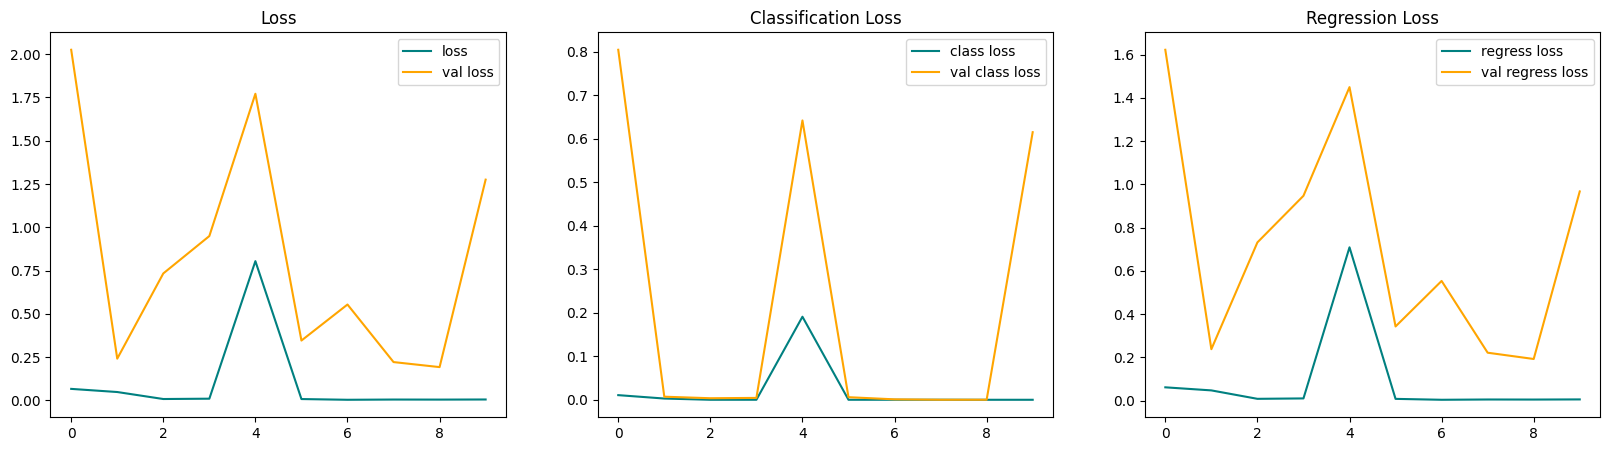

In [76]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [77]:
test_data = test.as_numpy_iterator()

In [78]:
test_sample = test_data.next()

In [79]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 26ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


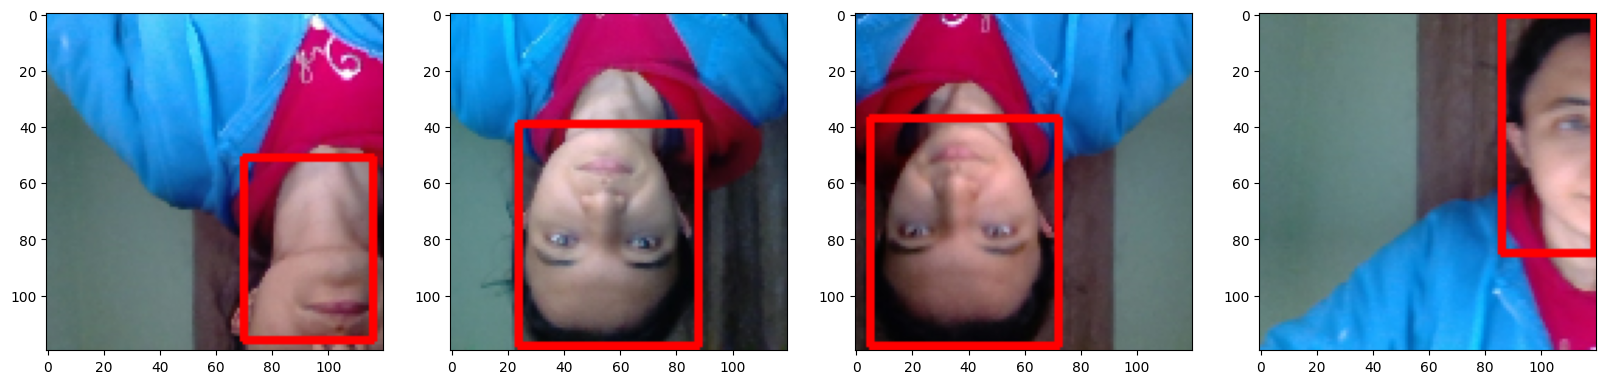

In [80]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [2]:
from tensorflow.keras.models import load_model

In [82]:
facetracker.save('facetracker.h5')

In [3]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [ ]:
import os
import time
import uuid
import cv2
from tensorflow.keras.models import load_model
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [4]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 12ms/step


KeyboardInterrupt: 

In [110]:
cv2.__version__

Found existing installation: opencv-python-headless 4.6.0.66
Uninstalling opencv-python-headless-4.6.0.66:
  Successfully uninstalled opencv-python-headless-4.6.0.66


ERROR: Exception:
Traceback (most recent call last):
  File "c:\users\acer\desktop\example4\example4\lib\site-packages\pip\_internal\cli\base_command.py", line 160, in exc_logging_wrapper
    status = run_func(*args)
  File "c:\users\acer\desktop\example4\example4\lib\site-packages\pip\_internal\commands\uninstall.py", line 103, in run
    uninstall_pathset.commit()
  File "c:\users\acer\desktop\example4\example4\lib\site-packages\pip\_internal\req\req_uninstall.py", line 424, in commit
    self._moved_paths.commit()
  File "c:\users\acer\desktop\example4\example4\lib\site-packages\pip\_internal\req\req_uninstall.py", line 277, in commit
    save_dir.cleanup()
  File "c:\users\acer\desktop\example4\example4\lib\site-packages\pip\_internal\utils\temp_dir.py", line 173, in cleanup
    rmtree(self._path)
  File "c:\users\acer\desktop\example4\example4\lib\site-packages\pip\_vendor\tenacity\__init__.py", line 328, in wrapped_f
    return self(f, *args, **kw)
  File "c:\users\acer\desktop\e

In [104]:
!pip install opencv-python==2.4.9